# Feature selection

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/207-feature_selection.ipynb)

This notebook contains the simple examples of using feature extractor transforms with ETNA library.

**Table of contents**

- [Loading dataset](#chapter_1)
- [Feature selection methods](#chapter_2)
    - [Intro to feature selection](#section_2_1)
    - [TreeFeatureSelectionTransform](#section_2_2)
    - [GaleShapleyFeatureSelectionTransform](#section_2_3)
    - [MRMRFeatureSelectionTransform](#section_2_4)
- [Summary](#chapter_3)

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import time
from copy import deepcopy

import pandas as pd

from etna.analysis import plot_backtest
from etna.datasets import TSDataset
from etna.metrics import SMAPE
from etna.models import CatBoostPerSegmentModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import FourierTransform
from etna.transforms import HolidayTransform
from etna.transforms import LagTransform
from etna.transforms import MeanTransform
from etna.transforms import TrendTransform

In [3]:
HORIZON = 60

## 1. Loading dataset <a class="anchor" id="chapter_1"></a>

We are going to work with the time series from [Tabular Playground Series - Jan 2022](https://www.kaggle.com/competitions/tabular-playground-series-jan-2022/overview). The dataset contains daily merchandise sales &mdash; mugs, hats, and stickers &mdash; at two imaginary store chains across three Scandinavian countries. As exogenous data, we will use Finland, Norway, and Sweden Weather Data 2015-2019 dataset containing daily country average precipitation, snow depth and air temperature data.

In [4]:
df = pd.read_csv("data/nordic_merch_sales.csv")

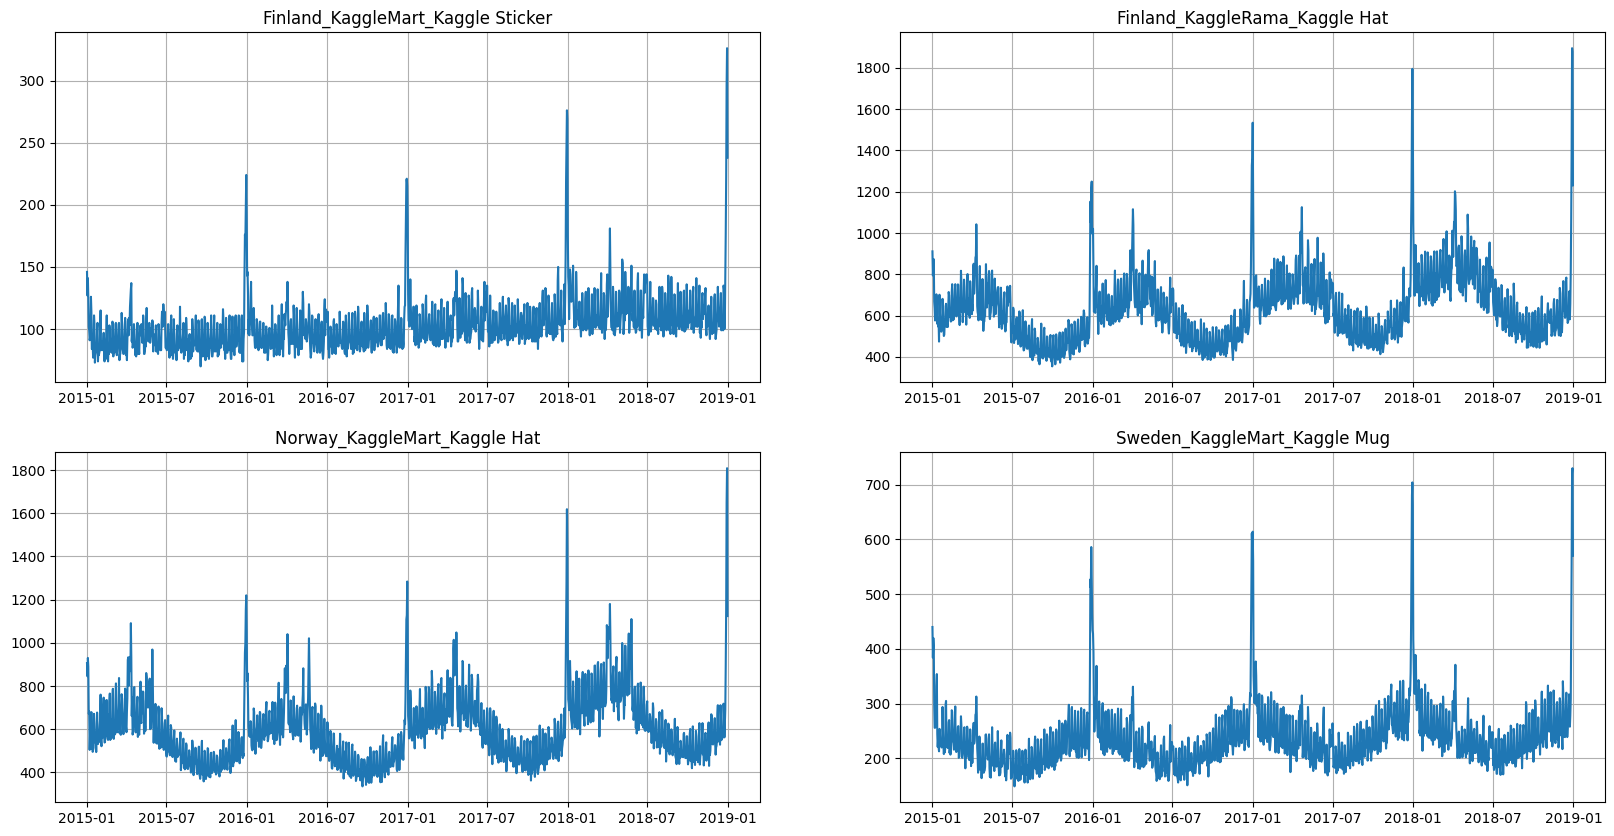

In [5]:
ts = TSDataset(df, freq="D")
ts.plot(4)

## 2. Feature selection methods <a class="anchor" id="chapter_2"></a>

### 2.1 Intro to feature selection <a class="anchor" id="section_2_1"></a>

Let's create features and build pipeline with dataset:

In [6]:
transforms = [
    TrendTransform(in_column="target", out_column="trend"),
    LagTransform(in_column="target", lags=range(HORIZON, 100), out_column="target_lag"),
    DateFlagsTransform(
        day_number_in_month=True, day_number_in_week=False, is_weekend=False, out_column="datetime_flag"
    ),
    MeanTransform(in_column=f"target_lag_{HORIZON}", window=12, seasonality=7, out_column="mean_transform"),
    FourierTransform(period=365, order=30, out_column="fourier_year"),
    FourierTransform(period=30.4, order=10, out_column="fourier_month"),
    HolidayTransform(iso_code="SWE", out_column="SWE_holidays"),
    HolidayTransform(iso_code="NOR", out_column="NOR_holidays"),
    HolidayTransform(iso_code="FIN", out_column="FIN_holidays"),
]

pipeline = Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON)

In [7]:
start_time = time.perf_counter()
backtest_result = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=1)
metrics_baseline = backtest_result["metrics_df"]
forecast_ts_list_baseline = backtest_result["forecasts"]
time_baseline = time.perf_counter() - start_time

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


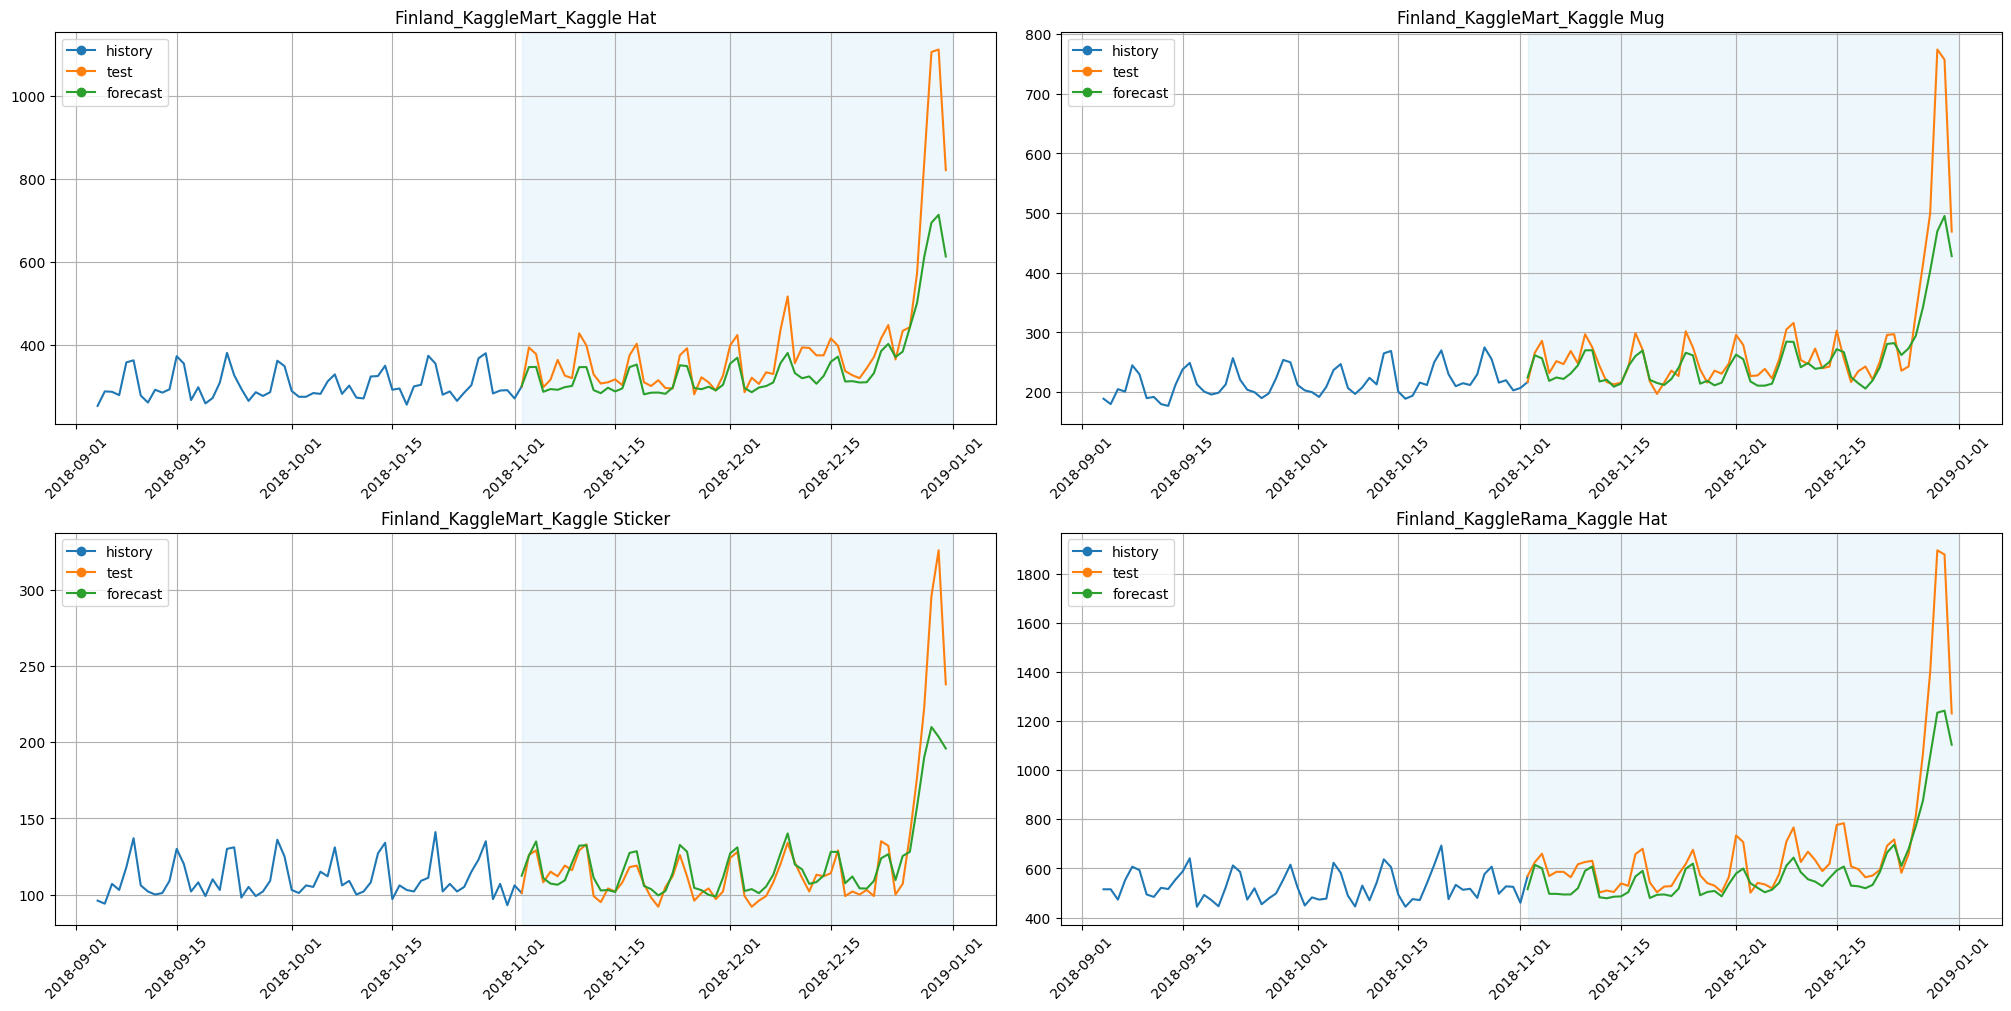

In [8]:
plot_backtest(forecast_ts_list_baseline, ts, history_len=60, segments=ts.segments[:4])

In [9]:
smape_baseline = metrics_baseline["SMAPE"].mean()
print(f"SMAPE baseline: {smape_baseline:.3f}")
print(f"Time baseline: {time_baseline:.3f}")

SMAPE baseline: 8.094
Time baseline: 67.688


Let's look how many features are used during fitting a model:

In [10]:
temp_ts = deepcopy(ts)
temp_ts.fit_transform(transforms=transforms)

num_features = len(temp_ts.features) - 1
print(f"Num features: {num_features}")

Num features: 126


We are subtracting 1, because `TSDataset.features` counts target as a feature.

Now our pipeline has too much features, takes a lot of time for `fit` and `predict` methods and shows not perfect metrics. ETNA provides some methods to optimize this situation by removing some features.

### 2.2 `TreeFeatureSelectionTransform` <a class="anchor" id="section_2_2"></a>

This method uses tree-based model to estimate importance of each feature. After that method leaves `top_k` best features. This class accepts as input the next parameters:

- `model`: model for estimating feature importance. Must have `fit` method and `feature_importances_` parameter;
- `top_k`: number of features to select;
- `features_to_use`: which features participate in feature selection;
- `return_features`: indicates whether to save features or not. It should be set to `True` only if you want to return features back to the dataset during `inverse_transform`.

Let's optimize our baseline:

In [11]:
from sklearn.tree import DecisionTreeRegressor

from etna.transforms import TreeFeatureSelectionTransform

model_feature_selection = DecisionTreeRegressor(random_state=42)
feature_selector_transform = TreeFeatureSelectionTransform(model=model_feature_selection, top_k=20)
pipeline = Pipeline(
    model=CatBoostPerSegmentModel(), transforms=transforms + [feature_selector_transform], horizon=HORIZON
)

In [12]:
start_time = time.perf_counter()
backtest_result = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=1)
metrics_tree_feature_selector = backtest_result["metrics_df"]
forecast_ts_list_tree_feature_selector = backtest_result["forecasts"]
time_tree_feature_selector = time.perf_counter() - start_time

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   33.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   33.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


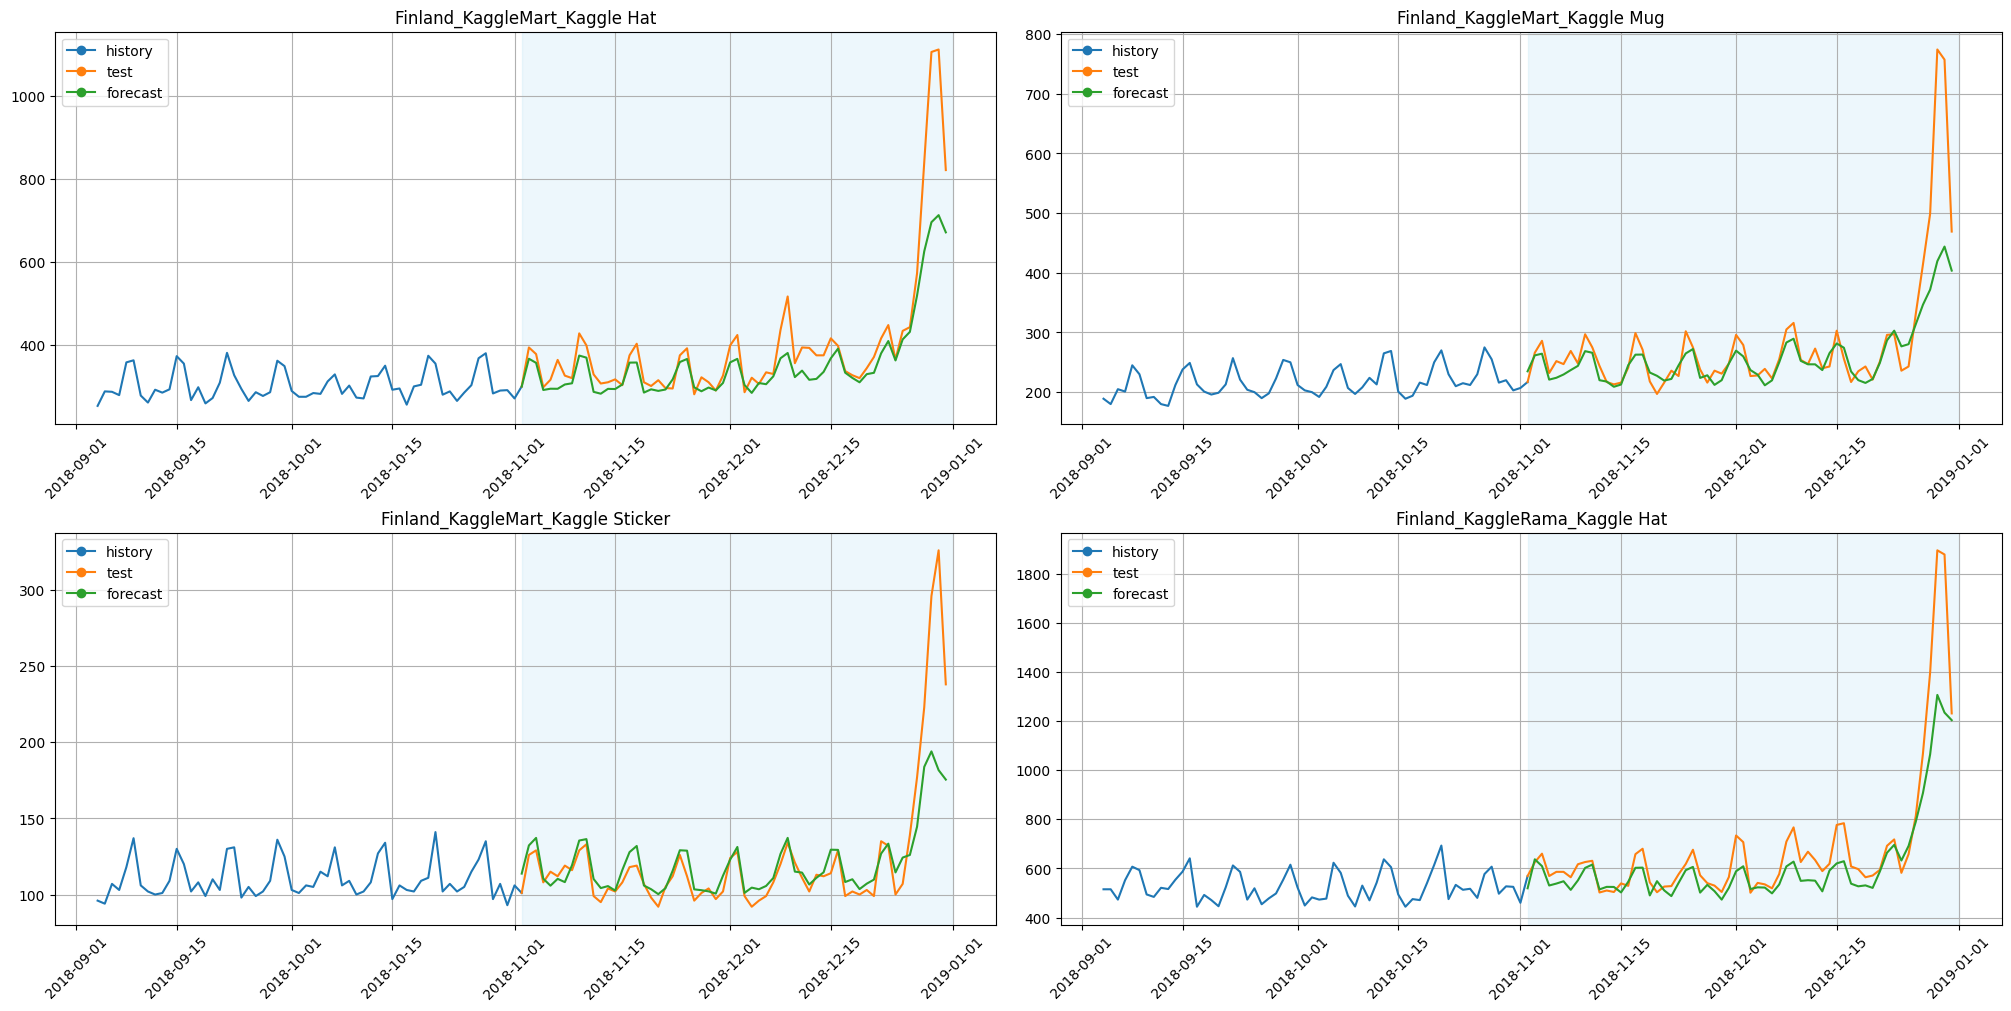

In [13]:
plot_backtest(forecast_ts_list_tree_feature_selector, ts, history_len=60, segments=ts.segments[:4])

Let's look whether metrics had improved or not:

In [14]:
smape_tree_feature_selector = metrics_tree_feature_selector["SMAPE"].mean()
print(f"SMAPE with TreeFeatureSelectionTransform: {smape_tree_feature_selector:.3f}")
print(f"Time with TreeFeatureSelectionTransform: {time_tree_feature_selector:.3f}")

SMAPE with TreeFeatureSelectionTransform: 7.595
Time with TreeFeatureSelectionTransform: 35.300


Results:

- SMAPE is better;
- time is less by around 65%.

ETNA also provides methods to plot importance of each feature:

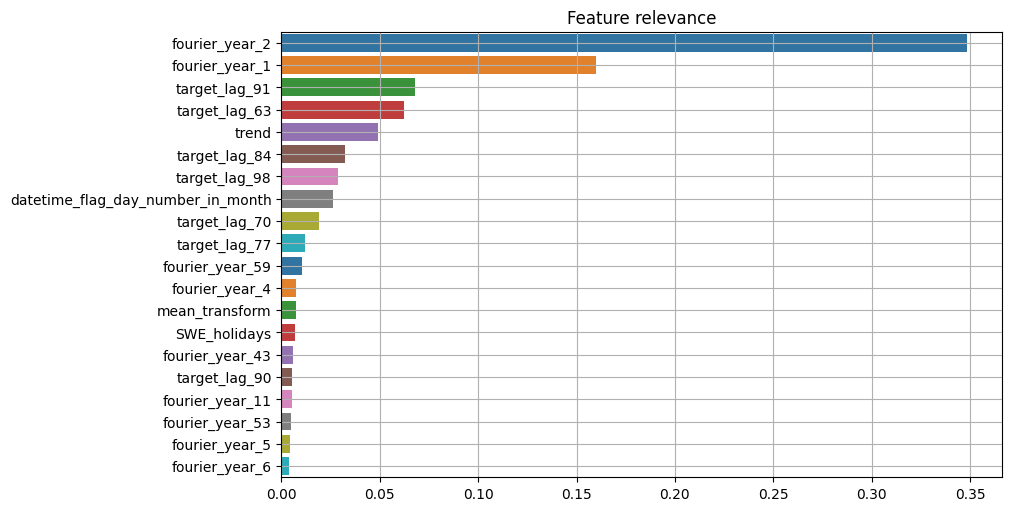

In [15]:
from etna.analysis import ModelRelevanceTable
from etna.analysis import plot_feature_relevance

temp_ts = deepcopy(ts)
temp_ts.fit_transform(transforms=transforms)

plot_feature_relevance(
    temp_ts,
    relevance_table=ModelRelevanceTable(),
    top_k=20,
    relevance_params={"model": model_feature_selection},
)

### 2.3 `GaleShapleyFeatureSelectionTransform` <a class="anchor" id="section_2_3"></a>

Let's assume that we have a table of relevances with size $N_{f} \times N_{s}$ where $N_{f}$ &mdash; number of features, $N_{s}$ &mdash; number of segments. 

Procedure of filtering features consist of $\lceil \frac{k}{N_{s}} \rceil$ iterations. Algorithm of each iteration:

- build a matching between segments and features by [Gale–Shapley algorithm](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm) according to the relevance table, during the matching segments send proposals to features;
- select features to add by taking matched feature for each segment;
- add selected features to accumulated list of selected features taking into account that this list shouldn't exceed the size of `top_k`;
- remove added features from future consideration.

In a library we have two possible ways to build such a table:

- `etna.analysis.StatisticsRelevanceTable`: calculates p-value relevances using `tsfresh`;
- `etna.analysis.ModelRelevanceTable`: calculate standard feature importance relevances using tree-based models.

In this example let's try `StatisticsRelevanceTable`.

In [16]:
from etna.analysis import StatisticsRelevanceTable
from etna.transforms import GaleShapleyFeatureSelectionTransform

rt = StatisticsRelevanceTable()
feature_selector_transform = GaleShapleyFeatureSelectionTransform(top_k=20, relevance_table=rt)
pipeline = Pipeline(
    model=CatBoostPerSegmentModel(), transforms=transforms + [feature_selector_transform], horizon=HORIZON
)

In [17]:
start_time = time.perf_counter()
backtest_result = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=1)
metrics_galeshapley_feature_selector = backtest_result["metrics_df"]
forecast_ts_list_galeshapley_feature_selector = backtest_result["forecasts"]
time_galeshapley_feature_selector = time.perf_counter() - start_time

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


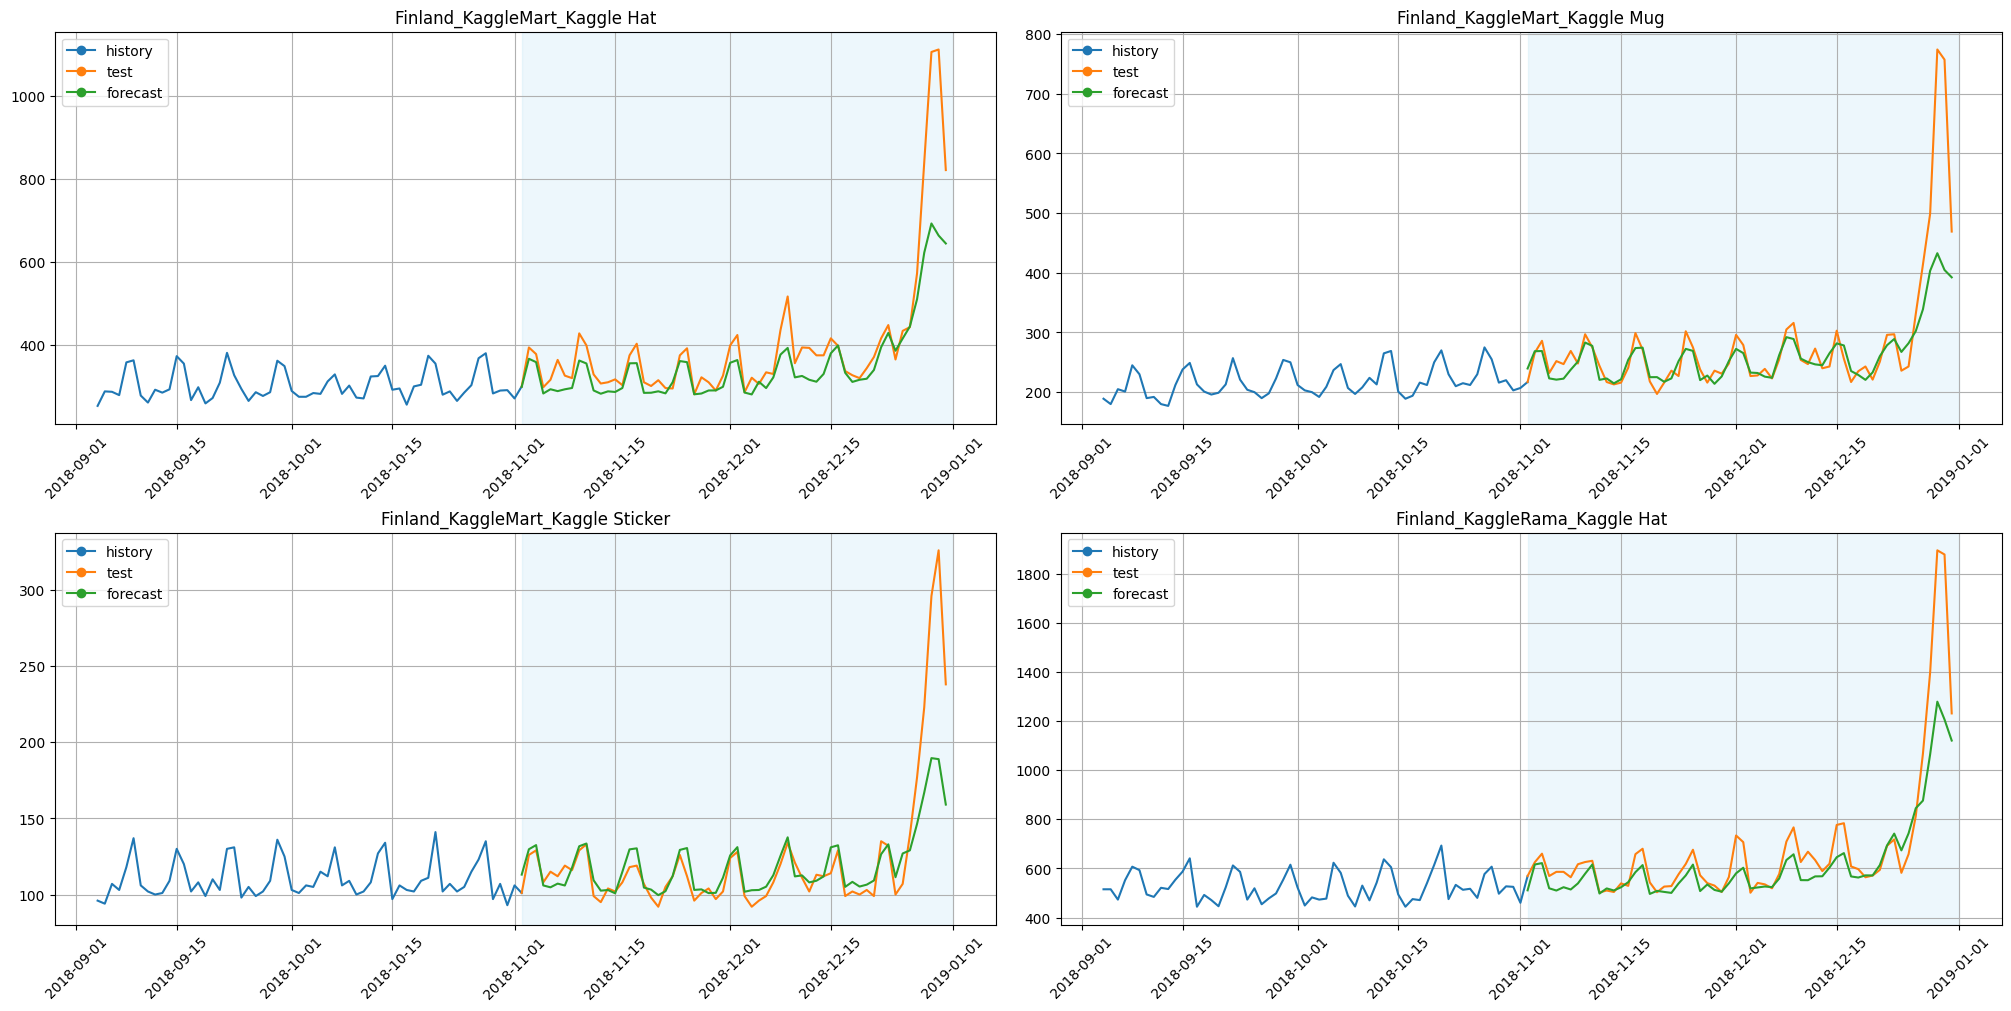

In [18]:
plot_backtest(forecast_ts_list_galeshapley_feature_selector, ts, history_len=60, segments=ts.segments[:4])

In [19]:
smape_galeshapley_feature_selector = metrics_galeshapley_feature_selector["SMAPE"].mean()
print(f"SMAPE with GaleShapleyFeatureSelectionTransform: {smape_galeshapley_feature_selector:.3f}")
print(f"Time with GaleShapleyFeatureSelectionTransform: {time_galeshapley_feature_selector:.3f}")

SMAPE with GaleShapleyFeatureSelectionTransform: 7.402
Time with GaleShapleyFeatureSelectionTransform: 82.049


Results:

- SMAPE is better;
- time is more by around 20%.

### 2.4 `MRMRFeatureSelectionTransform` <a class="anchor" id="section_2_4"></a>

The MRMR algorithm stands for "Maximum Relevance - Minimum Redundancy", the idea is to select features, which are informative for the target and aren't correlated with each other. At each iteration we select only one feature that has maximum relevance for the target and minimum redundancy with already selected set of features.

For achieving this we select the feature $f$ that maximizes the score:
$$
score(f) = \frac{\operatorname{relevance}(f | target)}{\operatorname{redundancy}(f | prev)},
$$

where $prev$ are previously selected features.

We use:
$$
\operatorname{relevance}(f | target) = \operatorname{F}(f, target),
\\
\operatorname{redundancy}(f | prev) = \sum_{s \in prev} |\rho(f, s)| \cdot \frac{1}{i-1},
$$

where $\operatorname{F}$ is F-statistic, $\rho$ is Pearson correlation, $i$ is number of iteration.

Let's look at example of usage. Now we are going to try `ModelRelevanceTable`.

In [20]:
from etna.transforms import MRMRFeatureSelectionTransform

rt = ModelRelevanceTable()
feature_selector_transform = MRMRFeatureSelectionTransform(
    top_k=20,
    relevance_table=rt,
    fast_redundancy=True,
    model=model_feature_selection,
)
pipeline = Pipeline(
    model=CatBoostPerSegmentModel(), transforms=transforms + [feature_selector_transform], horizon=HORIZON
)

Here we set `fast_redundancy=True` to use optimized version of the algorithm, it isn't default for backward compatibility.

In [21]:
start_time = time.perf_counter()
backtest_result = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=1)
metrics_mrmr_feature_selector = backtest_result["metrics_df"]
forecast_ts_list_mrmr_feature_selector = backtest_result["forecasts"]
time_mrmr_feature_selector = time.perf_counter() - start_time

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   42.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   42.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


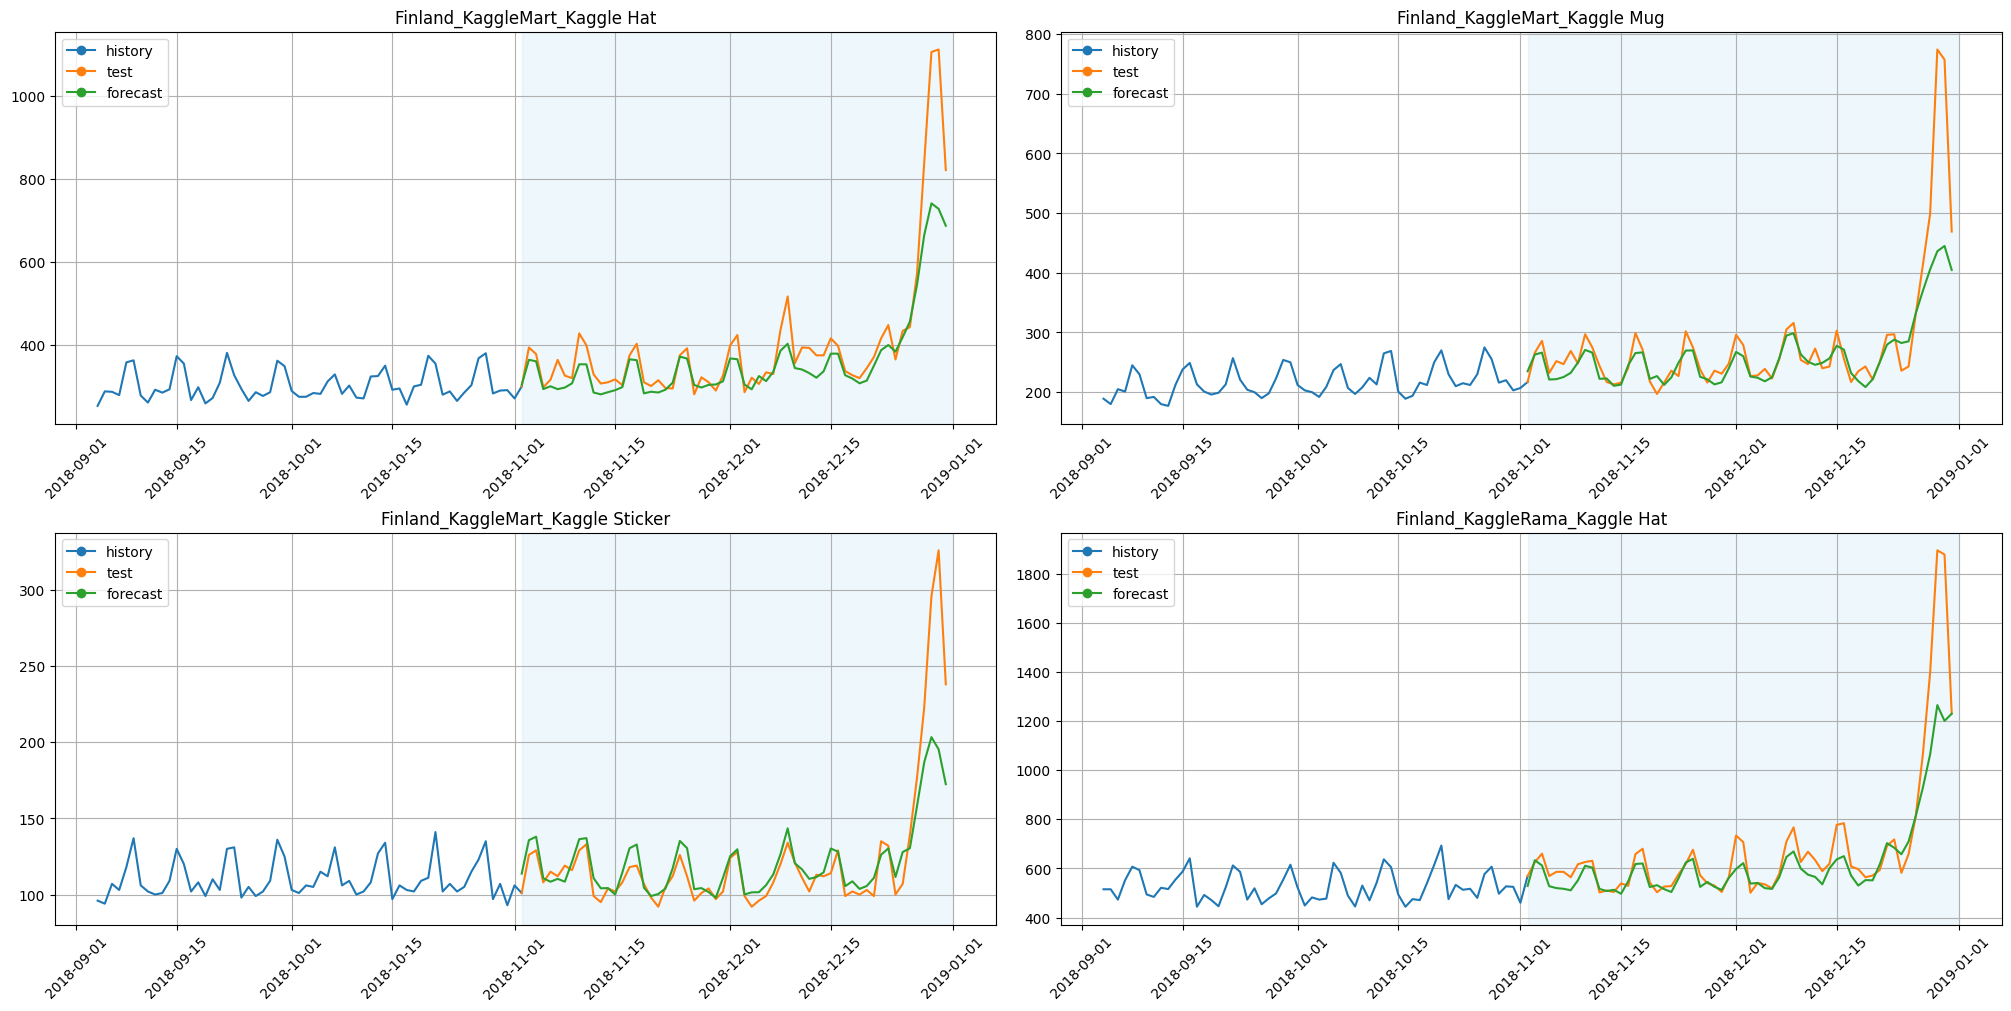

In [22]:
plot_backtest(forecast_ts_list_mrmr_feature_selector, ts, history_len=60, segments=ts.segments[:4])

In [23]:
smape_mrmr_feature_selector = metrics_mrmr_feature_selector["SMAPE"].mean()
print(f"SMAPE with MRMRFeatureSelectionTransform: {smape_mrmr_feature_selector:.3f}")
print(f"Time with MRMRFeatureSelectionTransform: {time_mrmr_feature_selector:.3f}")

SMAPE with MRMRFeatureSelectionTransform: 7.095
Time with MRMRFeatureSelectionTransform: 44.302


Results:

- SMAPE is better,
- time is less by around 35%.

## 3. Summary

In this notebook we have checked some methods of feature selection. As we have seen, such tricks can improve metrics and decrease runtime of your pipeline.